In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import re

from datetime import datetime
import numpy as np

import warnings
warnings.filterwarnings('ignore')

# 지수 표기법을 10진수로 변경
pd.set_option('display.float_format', '{:.2f}'.format)

import platform

system = platform.system()

if system == 'Windows':
    plt.rcParams['font.family'] = 'Malgun Gothic'
else:
    !apt-get -y install fonts-nanum
    !fc-cache -fv
    !rm ~/.cache/matplotlib -rf

    plt.rcParams['font.family'] = 'NanumBarunGothic'


입장 조건
* 롱 포지션:

    - 가격 > 200 SMA: 현재 가격은 200일 단순 이동 평균(SMA)보다 높아야 합니다.
    - MACD > 신호선: MACD 값이 신호선보다 높아 상승 모멘텀을 나타냅니다.
    - RSI > 50: 상대강도지수(RSI)가 50을 초과하여 강세 추세를 나타냅니다.
    - 현재 거래량 > 평균 거래량: 현재 거래량이 지난 50개 기간의 평균 거래량을 초과합니다.

* 매도 포지션:

    - 가격 < 200 SMA: 현재 가격이 200일 SMA보다 낮습니다.
    - MACD < 시그널선: MACD 값이 시그널선보다 작아 하락 모멘텀을 나타냅니다.
    - RSI < 50: RSI가 50 미만으로 약세 추세를 나타냅니다.
    - 현재 거래량 > 평균 거래량: 현재 거래량이 지난 50개 기간의 평균 거래량을 초과합니다.

종료 조건
* 롱 포지션:

    - 손절매: 진입 가격보다 낮은 특정 비율(예: 0.5% 또는 조정된 가격)로 설정합니다.
    - 전체 포지션 청산: 가격이 볼린저 밴드의 중간선에 닿을 때, 이는 추세 반전 가능성을 나타냅니다.

* 매도 포지션:

    - 손절매: 진입 가격보다 높은 특정 비율로 설정됩니다.
    - 전체 포지션 청산: 가격이 볼린저 밴드의 중간선에 닿을 때.


In [2]:
# backtest = pd.read_csv("./data/Grouped_Backtest_Results_by_Indicator.csv")
from backtest import back_testing
# from backtest_1 import back_testing
backtest = back_testing()

서버 시간 (UTC): 2024-10-18 04:31:38.647000
1분봉 마지막으로 저장된 데이터 시점: 2024-10-13 14:20:00
1분봉 저장된 데이터: 2024-10-13 05:20:00 - O: 62863.62, H: 62920.2, L: 62863.62, C: 62916.24, V: 9.747409
1분봉 저장된 데이터: 2024-10-13 05:21:00 - O: 62916.24, H: 62945.2, L: 62895.49, C: 62940.68, V: 16.615932
1분봉 저장된 데이터: 2024-10-13 05:22:00 - O: 62940.68, H: 62958.22, L: 62932.2, C: 62938.09, V: 8.167505
1분봉 저장된 데이터: 2024-10-13 05:23:00 - O: 62938.09, H: 62951.67, L: 62933.24, C: 62936.75, V: 3.613282
1분봉 저장된 데이터: 2024-10-13 05:24:00 - O: 62936.75, H: 62963.42, L: 62936.75, C: 62963.42, V: 5.70581
1분봉 저장된 데이터: 2024-10-13 05:25:00 - O: 62963.42, H: 62968.57, L: 62957.68, C: 62965.3, V: 5.686964
1분봉 저장된 데이터: 2024-10-13 05:26:00 - O: 62965.3, H: 62965.31, L: 62942.7, C: 62942.71, V: 5.23686
1분봉 저장된 데이터: 2024-10-13 05:27:00 - O: 62942.71, H: 62963.0, L: 62942.7, C: 62963.0, V: 2.77185
1분봉 저장된 데이터: 2024-10-13 05:28:00 - O: 62963.0, H: 62964.84, L: 62959.73, C: 62961.88, V: 3.663282
1분봉 저장된 데이터: 2024-10-13 05:29:00 - O: 6

In [3]:
backtest_long = backtest.query("Position == 'Long'")
backtest_short = backtest.query("Position == 'Short'")

In [4]:
backtest_long.describe()

,Entry_RSI,Exit_RSI,Max_Profit_RSI,Entry_MACD,Exit_MACD,Max_Profit_MACD,Entry_Signal_Line,Exit_Signal_Line,Max_Profit_Signal_Line,Entry_Bollinger_Percentage,Exit_Bollinger_Percentage,Max_Profit_Bollinger_Percentage,Entry_Time,Entry_Price,Exit_Time,Exit_Price,Profit_Loss,Max_Profit_Value,Max_Profit_Time
count,7.00,7.00,7.00,7.00,7.00,7.00,7.00,7.00,7.00,7.00,7.00,7.00,7,7.00,7,7.00,7.00,7.00,7
mean,85.90,83.96,85.14,429.14,427.54,431.96,334.92,353.44,346.68,85.49,78.90,81.79,2024-10-14 23:29:34.285714176,66133.07,2024-10-14 23:32:34.285714176,66059.81,-22.95,13.40,2024-10-14 23:31:17.142857216
min,74.79,70.40,78.56,400.58,385.85,389.26,235.68,276.99,276.99,68.29,58.09,68.29,2024-10-14 03:54:00,64241.40,2024-10-14 03:57:00,64216.66,-48.35,1.02,2024-10-14 03:57:00
25%,83.42,81.37,82.32,405.25,402.01,422.30,307.49,334.52,318.85,75.96,71.13,71.13,2024-10-14 04:04:30,64379.06,2024-10-14 04:07:30,64346.69,-26.06,2.49,2024-10-14 04:06:00
50%,87.69,84.63,86.83,429.84,435.36,431.90,345.52,363.49,345.52,87.56,81.78,86.23,2024-10-15 13:57:00,67261.58,2024-10-15 14:00:00,67016.97,-20.48,9.12,2024-10-15 14:00:00
75%,88.95,89.12,87.26,446.41,448.52,448.52,376.32,385.46,385.46,89.90,85.57,88.38,2024-10-15 14:06:00,67495.88,2024-10-15 14:09:00,67435.23,-14.03,23.29,2024-10-15 14:07:30
max,94.07,91.69,91.41,470.23,470.48,460.92,395.63,393.67,395.63,110.84,99.02,99.02,2024-10-15 14:15:00,67678.63,2024-10-15 14:18:00,67621.19,-11.68,32.06,2024-10-15 14:15:00
std,6.46,7.49,4.50,27.96,32.23,24.46,55.88,41.96,44.48,14.17,13.35,11.74,NaN,1689.13,NaN,1654.26,12.90,13.55,NaN


# 숏 분석

## 테스트 중 손실
- 탈출 전략이 잘못 적용 되었다는 것을 확인할 수 있음

In [5]:
backtest_short.query("Profit_Loss < 0")

,Position,Entry_RSI,Exit_RSI,Max_Profit_RSI,Entry_MACD,Exit_MACD,Max_Profit_MACD,Entry_Signal_Line,Exit_Signal_Line,Max_Profit_Signal_Line,Entry_Bollinger_Percentage,Exit_Bollinger_Percentage,Max_Profit_Bollinger_Percentage,Entry_Time,Entry_Price,Exit_Time,Exit_Price,Profit_Loss,Max_Profit_Value,Max_Profit_Time
7,Short,14.25,16.37,16.37,-280.95,-307.30,-307.30,-108.57,-148.31,-148.31,12.58,16.69,16.69,2024-10-15 14:57:00,65371.51,2024-10-15 15:00:00,65390.43,-14.90,14.25,2024-10-15 15:00:00
8,Short,14.38,21.69,14.38,-375.74,-382.84,-375.74,-224.32,-256.02,-224.32,12.69,21.90,12.69,2024-10-15 15:06:00,65010.95,2024-10-15 15:09:00,65228.44,-45.47,22.09,2024-10-15 15:06:00
10,Short,47.74,48.40,47.74,-302.33,-282.92,-302.33,-295.45,-292.94,-295.45,34.66,40.84,34.66,2024-10-15 15:21:00,65421.19,2024-10-15 15:24:00,65517.58,-26.74,5.50,2024-10-15 15:21:00
11,Short,26.57,30.85,26.57,-152.42,-156.84,-152.42,-98.68,-110.31,-98.68,4.50,14.76,4.50,2024-10-16 13:51:00,67253.94,2024-10-16 13:54:00,67307.80,-20.01,-8.40,2024-10-16 13:51:00


## 테스트 중 이익

In [6]:
backtest_short.query("Profit_Loss > 0")

,Position,Entry_RSI,Exit_RSI,Max_Profit_RSI,Entry_MACD,Exit_MACD,Max_Profit_MACD,Entry_Signal_Line,Exit_Signal_Line,Max_Profit_Signal_Line,Entry_Bollinger_Percentage,Exit_Bollinger_Percentage,Max_Profit_Bollinger_Percentage,Entry_Time,Entry_Price,Exit_Time,Exit_Price,Profit_Loss,Max_Profit_Value,Max_Profit_Time
9,Short,35.00,38.62,35.00,-329.37,-312.90,-329.37,-288.94,-293.73,-288.94,42.87,35.77,42.87,2024-10-15 15:15:00,65735.26,2024-10-15 15:18:00,65495.10,24.56,39.09,2024-10-15 15:15:00


## 정리

In [7]:
backtest_short.query("Profit_Loss < 0").describe()

,Entry_RSI,Exit_RSI,Max_Profit_RSI,Entry_MACD,Exit_MACD,Max_Profit_MACD,Entry_Signal_Line,Exit_Signal_Line,Max_Profit_Signal_Line,Entry_Bollinger_Percentage,Exit_Bollinger_Percentage,Max_Profit_Bollinger_Percentage,Entry_Time,Entry_Price,Exit_Time,Exit_Price,Profit_Loss,Max_Profit_Value,Max_Profit_Time
count,4.00,4.00,4.00,4.00,4.00,4.00,4.00,4.00,4.00,4.00,4.00,4.00,4,4.00,4,4.00,4.00,4.00,4
mean,25.74,29.33,26.27,-277.86,-282.47,-284.45,-181.75,-201.90,-191.69,16.11,23.55,17.14,2024-10-15 20:48:45,65764.40,2024-10-15 20:51:45,65861.06,-26.78,8.36,2024-10-15 20:49:30
min,14.25,16.37,14.38,-375.74,-382.84,-375.74,-295.45,-292.94,-295.45,4.50,14.76,4.50,2024-10-15 14:57:00,65010.95,2024-10-15 15:00:00,65228.44,-45.47,-8.40,2024-10-15 15:00:00
25%,14.35,20.36,15.87,-320.68,-326.19,-324.41,-242.10,-265.25,-242.10,10.56,16.21,10.64,2024-10-15 15:03:45,65281.37,2024-10-15 15:06:45,65349.93,-31.43,2.03,2024-10-15 15:04:30
50%,20.48,26.27,21.47,-291.64,-295.11,-304.82,-166.44,-202.17,-186.32,12.63,19.29,14.69,2024-10-15 15:13:30,65396.35,2024-10-15 15:16:30,65454.01,-23.38,9.88,2024-10-15 15:13:30
75%,31.86,35.24,31.86,-248.82,-251.40,-264.86,-106.09,-138.81,-135.90,18.18,26.63,21.18,2024-10-15 20:58:30,65879.38,2024-10-15 21:01:30,65965.14,-18.73,16.21,2024-10-15 20:58:30
max,47.74,48.40,47.74,-152.42,-156.84,-152.42,-98.68,-110.31,-98.68,34.66,40.84,34.66,2024-10-16 13:51:00,67253.94,2024-10-16 13:54:00,67307.80,-14.90,22.09,2024-10-16 13:51:00
std,15.77,14.05,15.28,92.96,93.94,94.18,94.86,86.56,86.34,12.95,11.91,12.74,NaN,1009.71,NaN,971.72,13.37,13.06,NaN


In [8]:
backtest_short.query("Profit_Loss > 0").describe()

,Entry_RSI,Exit_RSI,Max_Profit_RSI,Entry_MACD,Exit_MACD,Max_Profit_MACD,Entry_Signal_Line,Exit_Signal_Line,Max_Profit_Signal_Line,Entry_Bollinger_Percentage,Exit_Bollinger_Percentage,Max_Profit_Bollinger_Percentage,Entry_Time,Entry_Price,Exit_Time,Exit_Price,Profit_Loss,Max_Profit_Value,Max_Profit_Time
count,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1,1.00,1,1.00,1.00,1.00,1
mean,35.00,38.62,35.00,-329.37,-312.90,-329.37,-288.94,-293.73,-288.94,42.87,35.77,42.87,2024-10-15 15:15:00,65735.26,2024-10-15 15:18:00,65495.10,24.56,39.09,2024-10-15 15:15:00
min,35.00,38.62,35.00,-329.37,-312.90,-329.37,-288.94,-293.73,-288.94,42.87,35.77,42.87,2024-10-15 15:15:00,65735.26,2024-10-15 15:18:00,65495.10,24.56,39.09,2024-10-15 15:15:00
25%,35.00,38.62,35.00,-329.37,-312.90,-329.37,-288.94,-293.73,-288.94,42.87,35.77,42.87,2024-10-15 15:15:00,65735.26,2024-10-15 15:18:00,65495.10,24.56,39.09,2024-10-15 15:15:00
50%,35.00,38.62,35.00,-329.37,-312.90,-329.37,-288.94,-293.73,-288.94,42.87,35.77,42.87,2024-10-15 15:15:00,65735.26,2024-10-15 15:18:00,65495.10,24.56,39.09,2024-10-15 15:15:00
75%,35.00,38.62,35.00,-329.37,-312.90,-329.37,-288.94,-293.73,-288.94,42.87,35.77,42.87,2024-10-15 15:15:00,65735.26,2024-10-15 15:18:00,65495.10,24.56,39.09,2024-10-15 15:15:00
max,35.00,38.62,35.00,-329.37,-312.90,-329.37,-288.94,-293.73,-288.94,42.87,35.77,42.87,2024-10-15 15:15:00,65735.26,2024-10-15 15:18:00,65495.10,24.56,39.09,2024-10-15 15:15:00
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 롱

## 테스트 중 손실

In [9]:
backtest_long.query("Profit_Loss < 0")

,Position,Entry_RSI,Exit_RSI,Max_Profit_RSI,Entry_MACD,Exit_MACD,Max_Profit_MACD,Entry_Signal_Line,Exit_Signal_Line,Max_Profit_Signal_Line,Entry_Bollinger_Percentage,Exit_Bollinger_Percentage,Max_Profit_Bollinger_Percentage,Entry_Time,Entry_Price,Exit_Time,Exit_Price,Profit_Loss,Max_Profit_Value,Max_Profit_Time
0,Long,87.72,86.83,86.83,401.59,414.76,414.76,301.21,323.92,323.92,90.59,86.23,86.23,2024-10-14 03:54:00,64307.38,2024-10-14 03:57:00,64306.01,-12.21,1.02,2024-10-14 03:57:00
1,Long,87.69,84.18,87.69,431.90,435.36,431.90,345.52,363.49,345.52,87.56,81.78,87.56,2024-10-14 04:00:00,64450.74,2024-10-14 04:03:00,64387.37,-21.83,1.30,2024-10-14 04:00:00
2,Long,74.79,78.56,78.56,408.92,389.26,389.26,382.50,383.85,383.85,71.50,68.59,68.59,2024-10-14 04:09:00,64241.40,2024-10-14 04:12:00,64216.66,-15.85,3.69,2024-10-14 04:12:00
3,Long,94.07,91.41,91.41,400.58,442.22,442.22,235.68,276.99,276.99,110.84,99.02,99.02,2024-10-15 13:57:00,67678.63,2024-10-15 14:00:00,67621.19,-20.48,32.06,2024-10-15 14:00:00
4,Long,86.84,91.69,86.84,460.92,470.48,460.92,313.77,345.11,313.77,89.20,84.90,89.20,2024-10-15 14:03:00,67509.76,2024-10-15 14:06:00,67511.92,-11.68,31.81,2024-10-15 14:03:00
5,Long,90.18,84.63,84.63,470.23,454.83,454.83,370.14,387.08,387.08,80.42,73.66,73.66,2024-10-15 14:09:00,67481.99,2024-10-15 14:12:00,67358.53,-30.28,9.12,2024-10-15 14:12:00
6,Long,80.00,70.40,80.00,429.84,385.85,429.84,395.63,393.67,395.63,68.29,58.09,68.29,2024-10-15 14:15:00,67261.58,2024-10-15 14:18:00,67016.97,-48.35,14.78,2024-10-15 14:15:00


## 테스트 중 이익

In [10]:
backtest_long.query("Profit_Loss > 0")

,Position,Entry_RSI,Exit_RSI,Max_Profit_RSI,Entry_MACD,Exit_MACD,Max_Profit_MACD,Entry_Signal_Line,Exit_Signal_Line,Max_Profit_Signal_Line,Entry_Bollinger_Percentage,Exit_Bollinger_Percentage,Max_Profit_Bollinger_Percentage,Entry_Time,Entry_Price,Exit_Time,Exit_Price,Profit_Loss,Max_Profit_Value,Max_Profit_Time


## 정리

In [11]:
backtest_long.query("Profit_Loss < 0").describe()

,Entry_RSI,Exit_RSI,Max_Profit_RSI,Entry_MACD,Exit_MACD,Max_Profit_MACD,Entry_Signal_Line,Exit_Signal_Line,Max_Profit_Signal_Line,Entry_Bollinger_Percentage,Exit_Bollinger_Percentage,Max_Profit_Bollinger_Percentage,Entry_Time,Entry_Price,Exit_Time,Exit_Price,Profit_Loss,Max_Profit_Value,Max_Profit_Time
count,7.00,7.00,7.00,7.00,7.00,7.00,7.00,7.00,7.00,7.00,7.00,7.00,7,7.00,7,7.00,7.00,7.00,7
mean,85.90,83.96,85.14,429.14,427.54,431.96,334.92,353.44,346.68,85.49,78.90,81.79,2024-10-14 23:29:34.285714176,66133.07,2024-10-14 23:32:34.285714176,66059.81,-22.95,13.40,2024-10-14 23:31:17.142857216
min,74.79,70.40,78.56,400.58,385.85,389.26,235.68,276.99,276.99,68.29,58.09,68.29,2024-10-14 03:54:00,64241.40,2024-10-14 03:57:00,64216.66,-48.35,1.02,2024-10-14 03:57:00
25%,83.42,81.37,82.32,405.25,402.01,422.30,307.49,334.52,318.85,75.96,71.13,71.13,2024-10-14 04:04:30,64379.06,2024-10-14 04:07:30,64346.69,-26.06,2.49,2024-10-14 04:06:00
50%,87.69,84.63,86.83,429.84,435.36,431.90,345.52,363.49,345.52,87.56,81.78,86.23,2024-10-15 13:57:00,67261.58,2024-10-15 14:00:00,67016.97,-20.48,9.12,2024-10-15 14:00:00
75%,88.95,89.12,87.26,446.41,448.52,448.52,376.32,385.46,385.46,89.90,85.57,88.38,2024-10-15 14:06:00,67495.88,2024-10-15 14:09:00,67435.23,-14.03,23.29,2024-10-15 14:07:30
max,94.07,91.69,91.41,470.23,470.48,460.92,395.63,393.67,395.63,110.84,99.02,99.02,2024-10-15 14:15:00,67678.63,2024-10-15 14:18:00,67621.19,-11.68,32.06,2024-10-15 14:15:00
std,6.46,7.49,4.50,27.96,32.23,24.46,55.88,41.96,44.48,14.17,13.35,11.74,NaN,1689.13,NaN,1654.26,12.90,13.55,NaN


In [12]:
backtest_long.query("Profit_Loss > 0").describe()

,Entry_RSI,Exit_RSI,Max_Profit_RSI,Entry_MACD,Exit_MACD,Max_Profit_MACD,Entry_Signal_Line,Exit_Signal_Line,Max_Profit_Signal_Line,Entry_Bollinger_Percentage,Exit_Bollinger_Percentage,Max_Profit_Bollinger_Percentage,Entry_Time,Entry_Price,Exit_Time,Exit_Price,Profit_Loss,Max_Profit_Value,Max_Profit_Time
count,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0.00,0,0.00,0.00,0.00,0
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaT,NaN,NaN,NaN,NaT
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaT,NaN,NaN,NaN,NaT
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaT,NaN,NaN,NaN,NaT
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaT,NaN,NaN,NaN,NaT
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaT,NaN,NaN,NaN,NaT
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaT,NaN,NaN,NaN,NaT
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 시각화

In [13]:
check_value = 'Max_Profit_Value'
check_value = 'Profit_Loss'

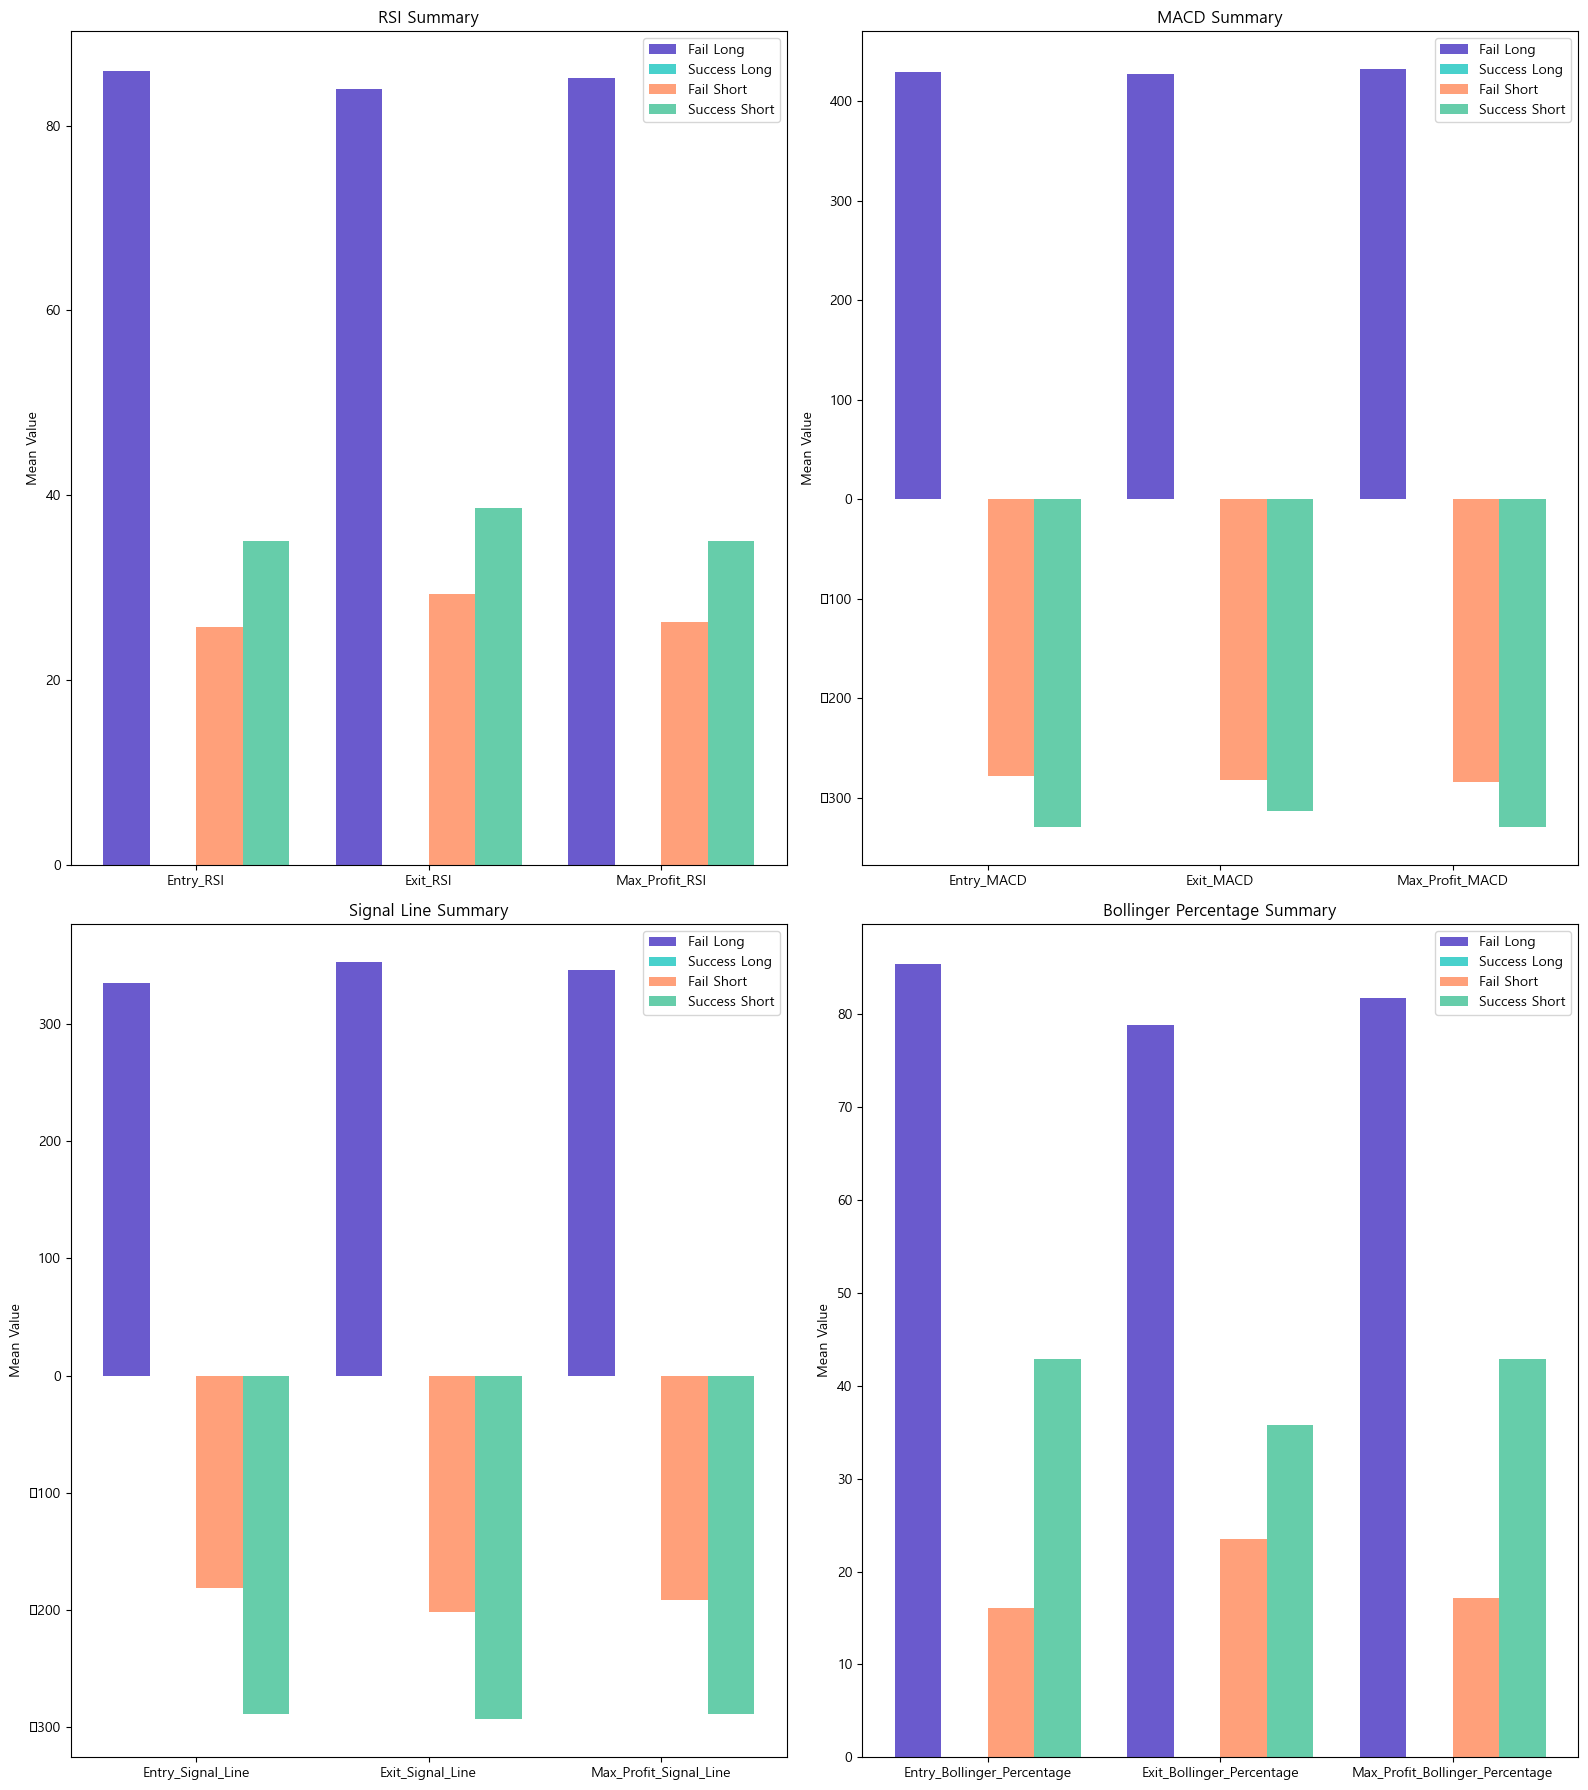

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# 성공과 실패, 롱과 숏에 대한 describe 데이터 가져오기
fail_long_desc = backtest_long.query(f"{check_value} < 0").describe()
success_long_desc = backtest_long.query(f"{check_value} > 0").describe()
fail_short_desc = backtest_short.query(f"{check_value} < 0").describe()
success_short_desc = backtest_short.query(f"{check_value} > 0").describe()

# 그래프 크기 설정
fig, axes = plt.subplots(2, 2, figsize=(16, 18))

# 각 지표별로 컬럼 묶음
rsi_columns = ['Entry_RSI', 'Exit_RSI', 'Max_Profit_RSI']
macd_columns = ['Entry_MACD', 'Exit_MACD', 'Max_Profit_MACD']
signal_columns = ['Entry_Signal_Line', 'Exit_Signal_Line', 'Max_Profit_Signal_Line']
bollinger_columns = ['Entry_Bollinger_Percentage', 'Exit_Bollinger_Percentage', 'Max_Profit_Bollinger_Percentage']

# 컬러 설정
colors = ['#6a5acd', '#48d1cc', '#ffa07a', '#66cdaa']  # 눈에 편한 색상들
bar_width = 0.2

# RSI 데이터 시각화
x = np.arange(len(rsi_columns))

axes[0, 0].bar(x - bar_width*1.5, fail_long_desc.loc['mean', rsi_columns], width=bar_width, color=colors[0], label='Fail Long')
axes[0, 0].bar(x - bar_width*0.5, success_long_desc.loc['mean', rsi_columns], width=bar_width, color=colors[1], label='Success Long')
axes[0, 0].bar(x + bar_width*0.5, fail_short_desc.loc['mean', rsi_columns], width=bar_width, color=colors[2], label='Fail Short')
axes[0, 0].bar(x + bar_width*1.5, success_short_desc.loc['mean', rsi_columns], width=bar_width, color=colors[3], label='Success Short')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(rsi_columns)
axes[0, 0].set_title("RSI Summary")
axes[0, 0].set_ylabel("Mean Value")
axes[0, 0].legend(loc='upper right')

# MACD 데이터 시각화
x = np.arange(len(macd_columns))
axes[0, 1].bar(x - bar_width*1.5, fail_long_desc.loc['mean', macd_columns], width=bar_width, color=colors[0], label='Fail Long')
axes[0, 1].bar(x - bar_width*0.5, success_long_desc.loc['mean', macd_columns], width=bar_width, color=colors[1], label='Success Long')
axes[0, 1].bar(x + bar_width*0.5, fail_short_desc.loc['mean', macd_columns], width=bar_width, color=colors[2], label='Fail Short')
axes[0, 1].bar(x + bar_width*1.5, success_short_desc.loc['mean', macd_columns], width=bar_width, color=colors[3], label='Success Short')
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(macd_columns)
axes[0, 1].set_title("MACD Summary")
axes[0, 1].set_ylabel("Mean Value")
axes[0, 1].legend(loc='upper right')

# Signal Line 데이터 시각화
x = np.arange(len(signal_columns))
axes[1, 0].bar(x - bar_width*1.5, fail_long_desc.loc['mean', signal_columns], width=bar_width, color=colors[0], label='Fail Long')
axes[1, 0].bar(x - bar_width*0.5, success_long_desc.loc['mean', signal_columns], width=bar_width, color=colors[1], label='Success Long')
axes[1, 0].bar(x + bar_width*0.5, fail_short_desc.loc['mean', signal_columns], width=bar_width, color=colors[2], label='Fail Short')
axes[1, 0].bar(x + bar_width*1.5, success_short_desc.loc['mean', signal_columns], width=bar_width, color=colors[3], label='Success Short')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(signal_columns)
axes[1, 0].set_title("Signal Line Summary")
axes[1, 0].set_ylabel("Mean Value")
axes[1, 0].legend(loc='upper right')

# Bollinger Percentage 데이터 시각화
x = np.arange(len(bollinger_columns))
axes[1, 1].bar(x - bar_width*1.5, fail_long_desc.loc['mean', bollinger_columns], width=bar_width, color=colors[0], label='Fail Long')
axes[1, 1].bar(x - bar_width*0.5, success_long_desc.loc['mean', bollinger_columns], width=bar_width, color=colors[1], label='Success Long')
axes[1, 1].bar(x + bar_width*0.5, fail_short_desc.loc['mean', bollinger_columns], width=bar_width, color=colors[2], label='Fail Short')
axes[1, 1].bar(x + bar_width*1.5, success_short_desc.loc['mean', bollinger_columns], width=bar_width, color=colors[3], label='Success Short')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(bollinger_columns)
axes[1, 1].set_title("Bollinger Percentage Summary")
axes[1, 1].set_ylabel("Mean Value")
axes[1, 1].legend(loc='upper right')

# 레이아웃 조정
plt.tight_layout()
plt.show()


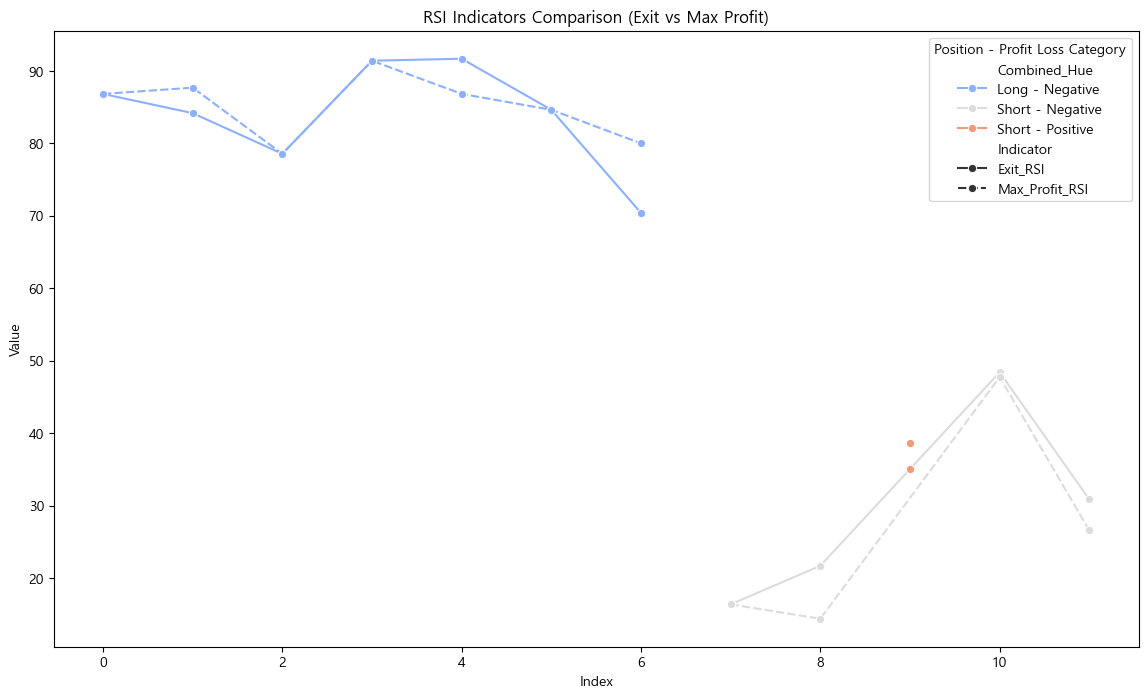

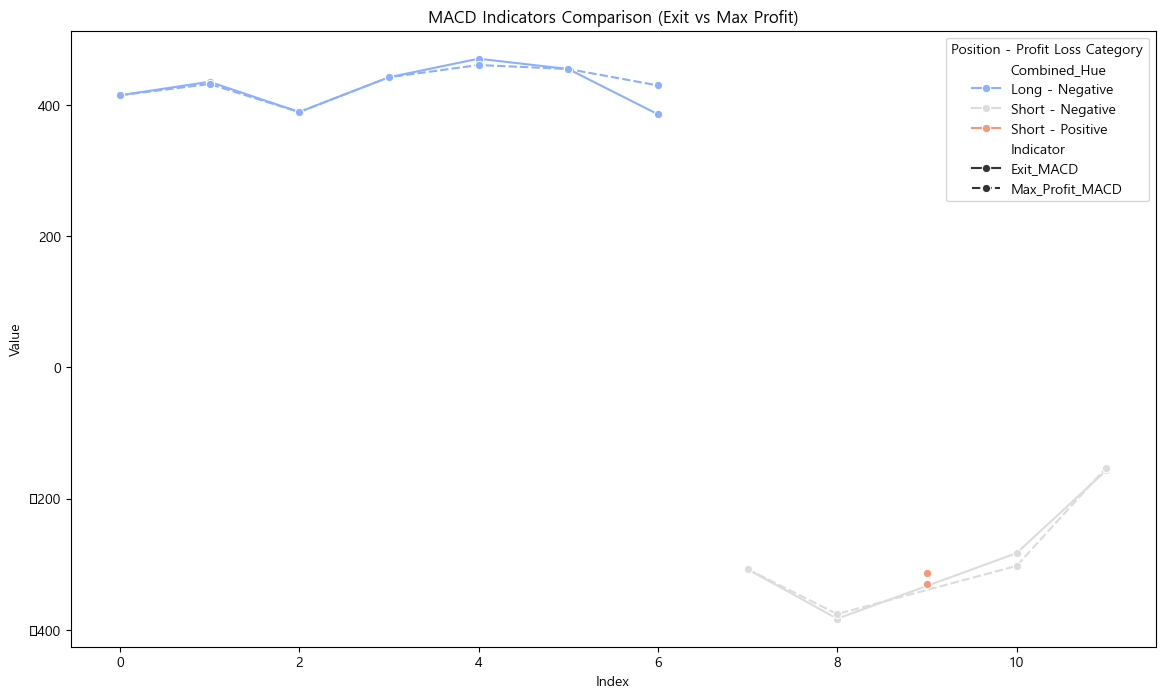

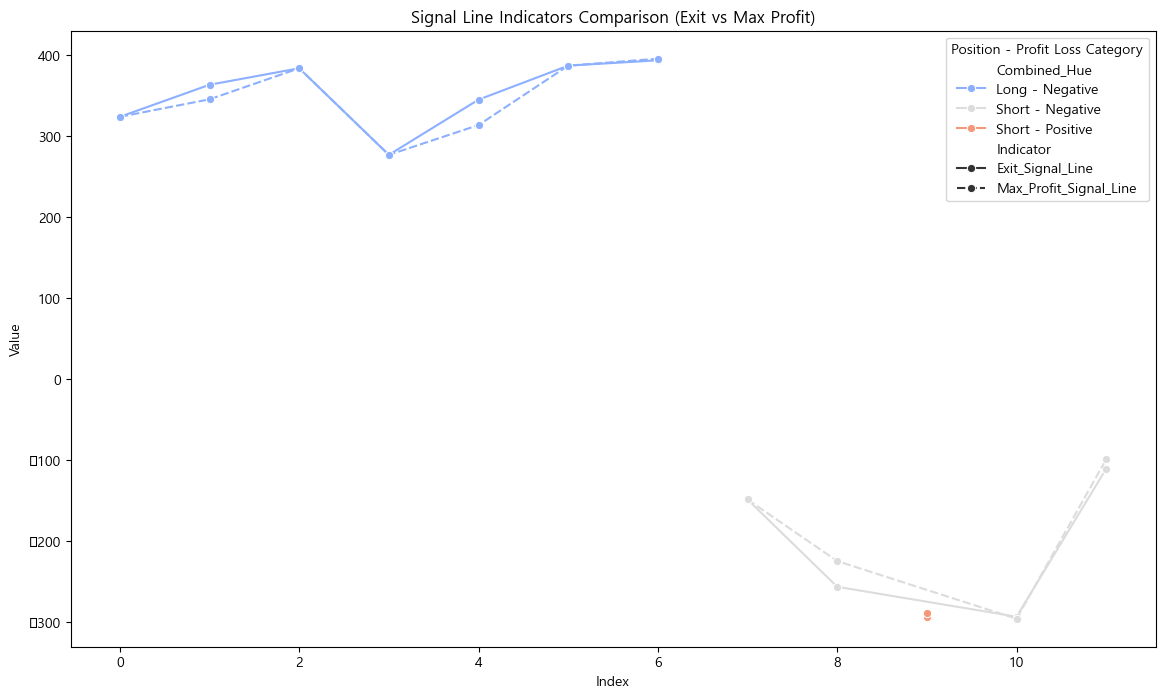

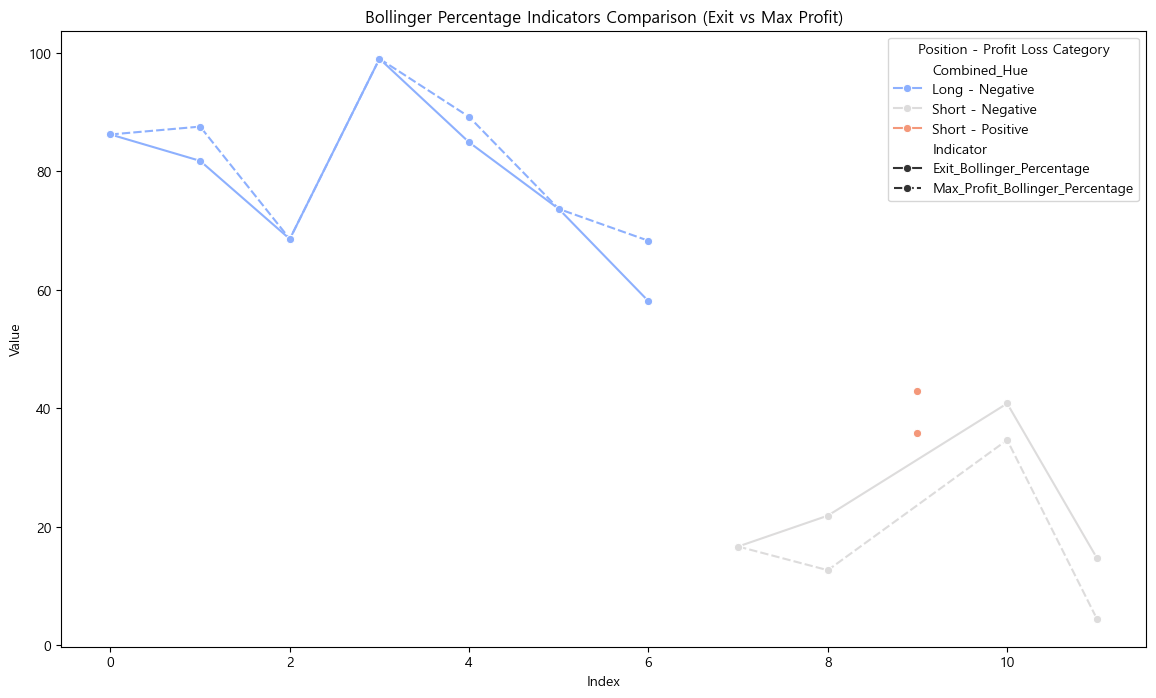

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming you have combined_data from backtest_long and backtest_short data
combined_data = pd.concat([backtest_long, backtest_short])

# Define indicator groups
exit_indicators = ["Exit_RSI", "Exit_MACD", "Exit_Signal_Line", "Exit_Bollinger_Percentage"]
max_profit_indicators = ["Max_Profit_RSI", "Max_Profit_MACD", "Max_Profit_Signal_Line", "Max_Profit_Bollinger_Percentage"]

# Melt the data
plot_data = combined_data.melt(id_vars=["Position", f"{check_value}"], 
                               value_vars=exit_indicators + max_profit_indicators,
                               var_name="Indicator", value_name="Value")

# Create a combined hue for Position and Profit_Loss
plot_data["Profit_Loss_Category"] = plot_data[f"{check_value}"].apply(lambda x: "Positive" if x > 0 else "Negative")
plot_data["Combined_Hue"] = plot_data["Position"] + " - " + plot_data["Profit_Loss_Category"]

# Add a numeric index column for x-axis, grouped by each Indicator
plot_data["Index"] = plot_data.groupby("Indicator").cumcount()

# Plot RSI indicators
plt.figure(figsize=(14, 8))
sns.lineplot(data=plot_data[plot_data["Indicator"].isin(["Exit_RSI", "Max_Profit_RSI"])],
             x="Index", y="Value", hue="Combined_Hue", style="Indicator", marker="o", palette="coolwarm")
plt.title("RSI Indicators Comparison (Exit vs Max Profit)")
plt.xlabel("Index")
plt.ylabel("Value")
plt.legend(title="Position - Profit Loss Category")
plt.show()

# Plot MACD indicators
plt.figure(figsize=(14, 8))
sns.lineplot(data=plot_data[plot_data["Indicator"].isin(["Exit_MACD", "Max_Profit_MACD"])],
             x="Index", y="Value", hue="Combined_Hue", style="Indicator", marker="o", palette="coolwarm")
plt.title("MACD Indicators Comparison (Exit vs Max Profit)")
plt.xlabel("Index")
plt.ylabel("Value")
plt.legend(title="Position - Profit Loss Category")
plt.show()

# Plot Signal Line indicators
plt.figure(figsize=(14, 8))
sns.lineplot(data=plot_data[plot_data["Indicator"].isin(["Exit_Signal_Line", "Max_Profit_Signal_Line"])],
             x="Index", y="Value", hue="Combined_Hue", style="Indicator", marker="o", palette="coolwarm")
plt.title("Signal Line Indicators Comparison (Exit vs Max Profit)")
plt.xlabel("Index")
plt.ylabel("Value")
plt.legend(title="Position - Profit Loss Category")
plt.show()

# Plot Bollinger Percentage indicators
plt.figure(figsize=(14, 8))
sns.lineplot(data=plot_data[plot_data["Indicator"].isin(["Exit_Bollinger_Percentage", "Max_Profit_Bollinger_Percentage"])],
             x="Index", y="Value", hue="Combined_Hue", style="Indicator", marker="o", palette="coolwarm")
plt.title("Bollinger Percentage Indicators Comparison (Exit vs Max Profit)")
plt.xlabel("Index")
plt.ylabel("Value")
plt.legend(title="Position - Profit Loss Category")
plt.show()


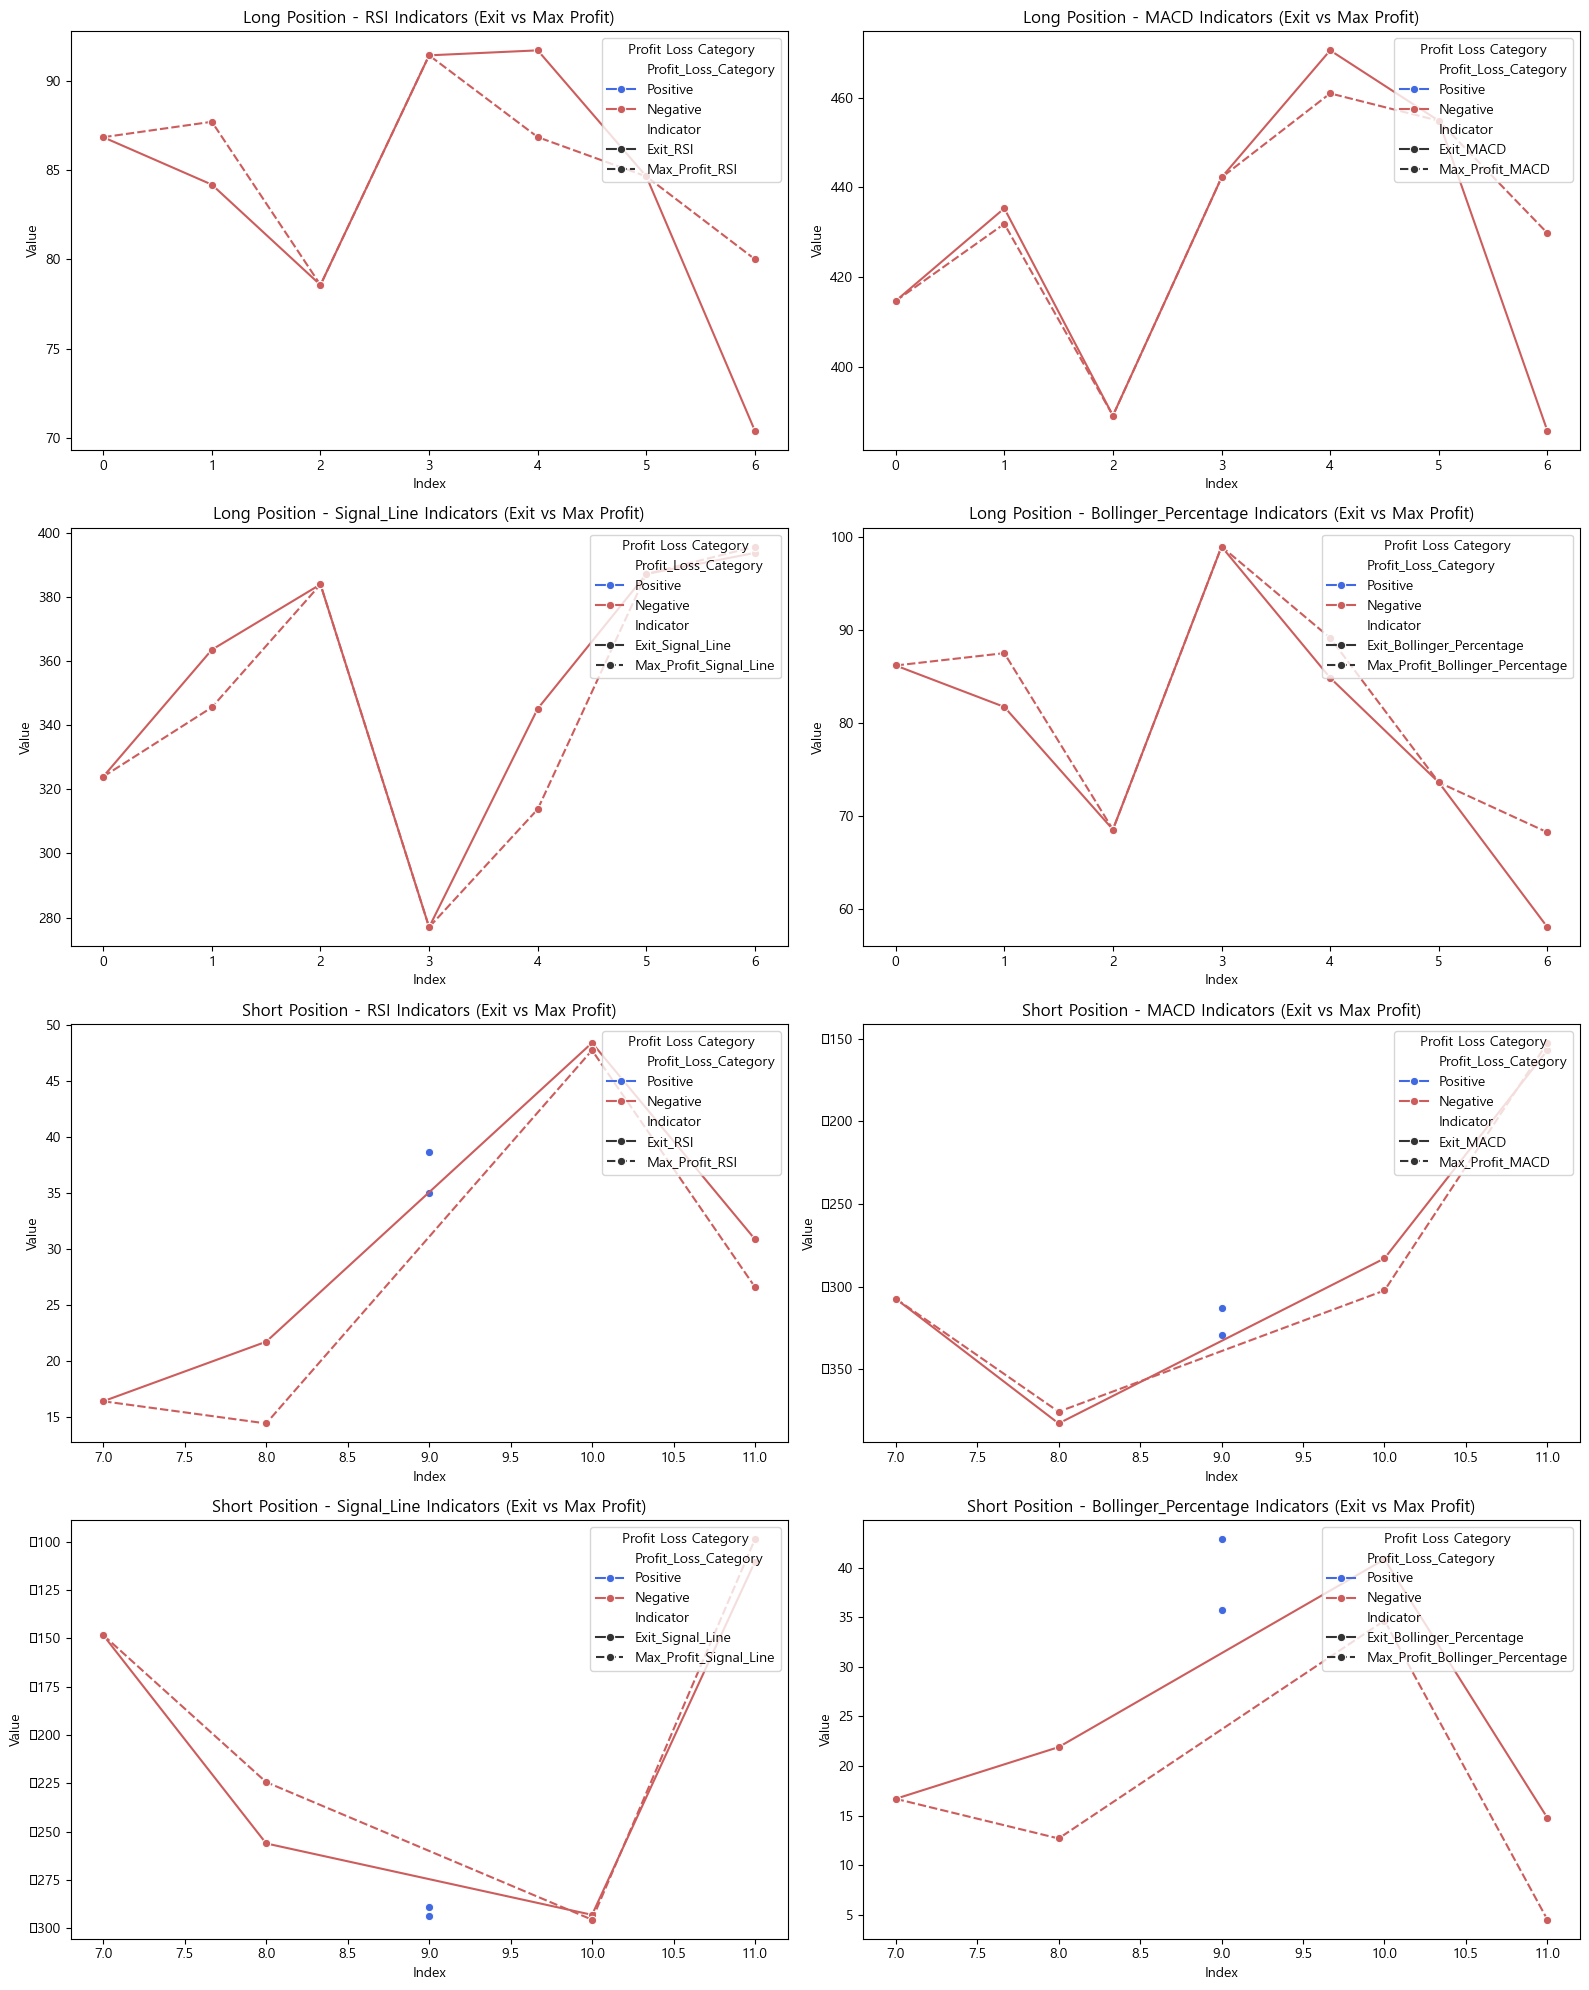

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming combined_data is your concatenated dataframe of backtest_long and backtest_short
# combined_data = pd.concat([backtest_long, backtest_short])

# Define indicator groups
exit_indicators = ["Exit_RSI", "Exit_MACD", "Exit_Signal_Line", "Exit_Bollinger_Percentage"]
max_profit_indicators = ["Max_Profit_RSI", "Max_Profit_MACD", "Max_Profit_Signal_Line", "Max_Profit_Bollinger_Percentage"]

# Melt the data
plot_data = combined_data.melt(id_vars=["Position", f"{check_value}"], 
                               value_vars=exit_indicators + max_profit_indicators,
                               var_name="Indicator", value_name="Value")

# Create a combined hue for Profit_Loss
plot_data["Profit_Loss_Category"] = plot_data[f"{check_value}"].apply(lambda x: "Positive" if x > 0 else "Negative")

# Add a numeric index column for x-axis, grouped by each Indicator
plot_data["Index"] = plot_data.groupby("Indicator").cumcount()

# Plot setup for 8 graphs
plt.figure(figsize=(16, 20))
positions = ["Long", "Short"]
indicators = ["RSI", "MACD", "Signal_Line", "Bollinger_Percentage"]
indicator_pairs = {
    "RSI": ["Exit_RSI", "Max_Profit_RSI"],
    "MACD": ["Exit_MACD", "Max_Profit_MACD"],
    "Signal_Line": ["Exit_Signal_Line", "Max_Profit_Signal_Line"],
    "Bollinger_Percentage": ["Exit_Bollinger_Percentage", "Max_Profit_Bollinger_Percentage"]
}

# Set palette for positive and negative categories
custom_palette = {"Positive": "royalblue", "Negative": "indianred"}

# Loop through positions and indicators
for pos_idx, pos in enumerate(positions):
    for ind_idx, ind in enumerate(indicators):
        plt.subplot(4, 2, pos_idx * 4 + ind_idx + 1)
        
        # Filter data based on Position and specific indicator pair
        data = plot_data[(plot_data["Position"] == pos) & 
                         (plot_data["Indicator"].isin(indicator_pairs[ind]))]
        
        # Create line plot for the filtered data
        sns.lineplot(data=data, x="Index", y="Value", 
                     hue="Profit_Loss_Category", style="Indicator", marker="o", 
                     hue_order=["Positive", "Negative"], palette=custom_palette)
        
        plt.title(f"{pos} Position - {ind} Indicators (Exit vs Max Profit)")
        plt.xlabel("Index")
        plt.ylabel("Value")
        plt.legend(title="Profit Loss Category", loc='upper right')

plt.tight_layout()
plt.show()


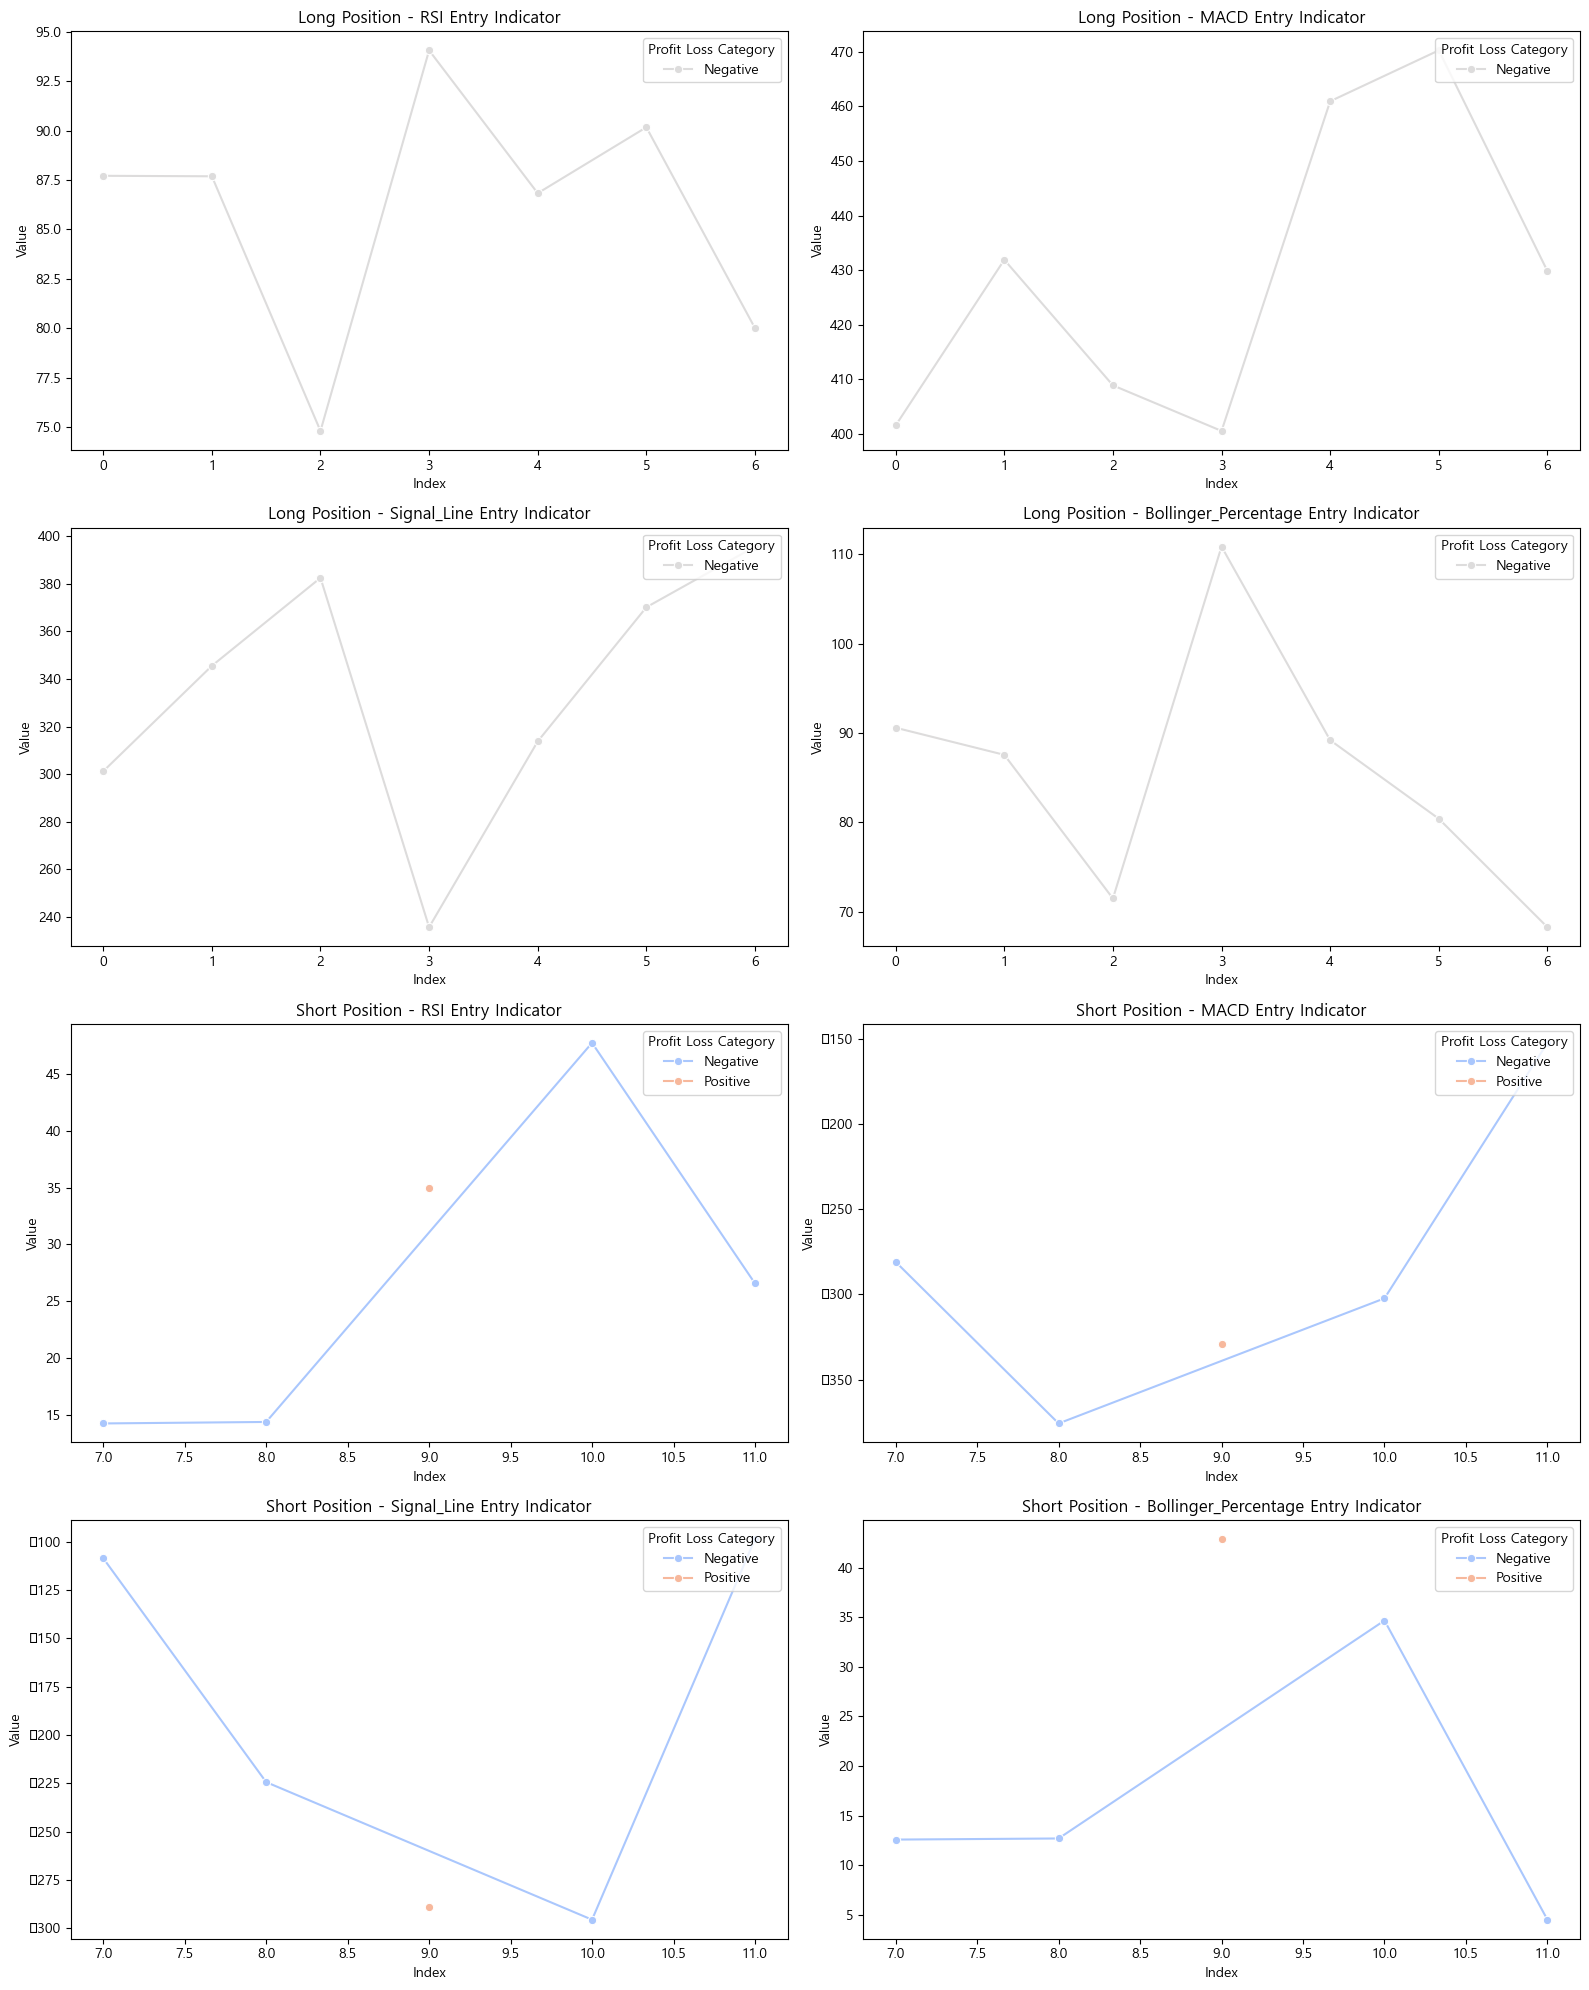

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming combined_data is your concatenated dataframe of backtest_long and backtest_short
# combined_data = pd.concat([backtest_long, backtest_short])

# Define indicator groups for entry, exit, and max profit
entry_indicators = ["Entry_RSI", "Entry_MACD", "Entry_Signal_Line", "Entry_Bollinger_Percentage"]

# Melt the data to include entry indicators
plot_data = combined_data.melt(id_vars=["Position", f"{check_value}"], 
                               value_vars=entry_indicators,
                               var_name="Indicator", value_name="Value")

# Create a combined hue for Profit_Loss
plot_data["Profit_Loss_Category"] = plot_data[f"{check_value}"].apply(lambda x: "Positive" if x > 0 else "Negative")

# Add a numeric index column for x-axis, grouped by each Indicator
plot_data["Index"] = plot_data.groupby("Indicator").cumcount()

# Plot setup for 4 graphs (Long and Short positions separated for each indicator)
plt.figure(figsize=(16, 20))
positions = ["Long", "Short"]
indicators = ["RSI", "MACD", "Signal_Line", "Bollinger_Percentage"]
indicator_pairs_entry = {
    "RSI": ["Entry_RSI"],
    "MACD": ["Entry_MACD"],
    "Signal_Line": ["Entry_Signal_Line"],
    "Bollinger_Percentage": ["Entry_Bollinger_Percentage"]
}

# Loop through positions and entry indicators
for pos_idx, pos in enumerate(positions):
    for ind_idx, ind in enumerate(indicators):
        plt.subplot(4, 2, pos_idx * 4 + ind_idx + 1)
        
        # Filter data based on Position and specific entry indicator
        data = plot_data[(plot_data["Position"] == pos) & 
                         (plot_data["Indicator"].isin(indicator_pairs_entry[ind]))]
        
        # Create line plot for the filtered data
        sns.lineplot(data=data, x="Index", y="Value", 
                     hue="Profit_Loss_Category", marker="o", palette="coolwarm")
        plt.title(f"{pos} Position - {ind} Entry Indicator")
        plt.xlabel("Index")
        plt.ylabel("Value")
        plt.legend(title="Profit Loss Category", loc='upper right')

plt.tight_layout()
plt.show()
